# simulation results for first prototype at TAU - count photons in SiPM array and estimate time resolution 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle, Ellipse
path = '/Users/erezcohen/Desktop/data/DuSiHodSim/output/csv_files/';

In [2]:
def set_axes_fontsize(ax,fontsize):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

In [5]:
def ComputeNPhotonsArrivingAtWGmarginExit(  version=9.0,
                                            WGname = 'WGfrontSide40_length300',
                                            repIdx=1,
                                            fdebug=0
                                     ): 

    scenario_name='EJ204_%s'%(WGname)
    sim_results = pd.read_csv(path + scenario_name + '/' + 'rep_%d.csv'%repIdx);
    
    ArrivedAtFrontFacet = sim_results[  (sim_results['ArrivedAtFrontFacet']==1)                                       
                                      & (sim_results['AbsorbedInScintillator']==0)                                     
                                      & (sim_results['HitBackFacet']==0)]
    
    ArrivedAtWaveguideMarginExit = ArrivedAtFrontFacet[(ArrivedAtFrontFacet['ArrivedAtWaveguideMarginExit']==1) 
                                                 & (ArrivedAtFrontFacet['AbsorbedInWaveguide']==0)]
    PhotonsInExit = ArrivedAtWaveguideMarginExit

    # in SiPM array
    # https://www.ketek.net/wp-content/uploads/2016/12/KETEK-PA3325-WB-0808-Datasheet.pdf
    Xtot = 25.32
    aSiPM = 3; # [mm]
    xSiPMs = np.linspace(-Xtot/2,Xtot/2,8)
    ySiPMs = xSiPMs

    InSiPMarea = pd.DataFrame();
    for xSiPM in xSiPMs:#{
        for ySiPM in ySiPMs:#{
            InSiPMarea = pd.concat([InSiPMarea , 
                                    ArrivedAtWaveguideMarginExit[   (np.abs((ArrivedAtWaveguideMarginExit.HitWaveguideMarginExitPosX-xSiPM))< float(aSiPM)/2)                        
                                                            & (np.abs((ArrivedAtWaveguideMarginExit.HitWaveguideMarginExitPosY-ySiPM))< float(aSiPM)/2)] ])
        #}
    #}

    return [InSiPMarea,PhotonsInExit]

In [6]:
[InSiPM,PhotonsInExit] = ComputeNPhotonsArrivingAtWGmarginExit(WGname='WG_side27mm_length200_margin3cm');
NSiPM = len(InSiPM);    

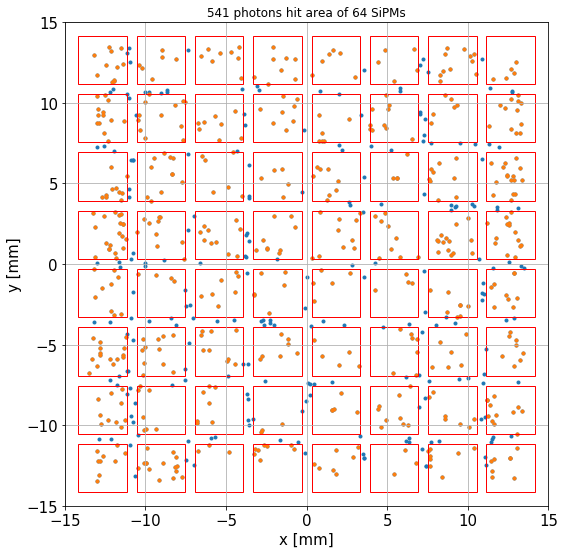

In [7]:
# in SiPM array
InSiPMarea = pd.DataFrame();
# https://www.ketek.net/wp-content/uploads/2016/12/KETEK-PA3325-WB-0808-Datasheet.pdf
Xtot = 25.32
aSiPM = 3; # [mm]
xSiPMs = np.linspace(-Xtot/2,Xtot/2,8)
ySiPMs = xSiPMs

for xSiPM in xSiPMs:
    for ySiPM in ySiPMs:
        InSiPMarea = pd.concat([InSiPMarea , 
                            PhotonsInExit[ (np.abs((PhotonsInExit.HitWaveguideExitPosX-xSiPM))< float(aSiPM)/2)                        
                                                    & (np.abs((PhotonsInExit.HitWaveguideExitPosY-ySiPM))< float(aSiPM)/2)] ])
        
figure,ax = plt.subplots(figsize=(8,8));
plt.scatter( PhotonsInExit.HitWaveguideExitPosX, PhotonsInExit.HitWaveguideExitPosY , marker='.')
plt.scatter( InSiPMarea.HitWaveguideExitPosX, InSiPMarea.HitWaveguideExitPosY , marker='.')
for xSiPM in xSiPMs:
    for ySiPM in ySiPMs:
        rect = Rectangle((xSiPM-float(aSiPM)/2,
                          ySiPM-float(aSiPM)/2),
                         aSiPM,
                         aSiPM,
                         linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

ax.set_xlabel('x [mm]',fontsize=15);
ax.set_ylabel('y [mm]',fontsize=15);
ax.set_title('%d photons hit area of 64 SiPMs'%len(InSiPMarea));
set_axes_fontsize(ax,15)
ax.set_aspect('equal')
ax.grid()
plt.tight_layout()
ax.set_xlim(-30/2,30/2);ax.set_ylim(-30/2,30/2);


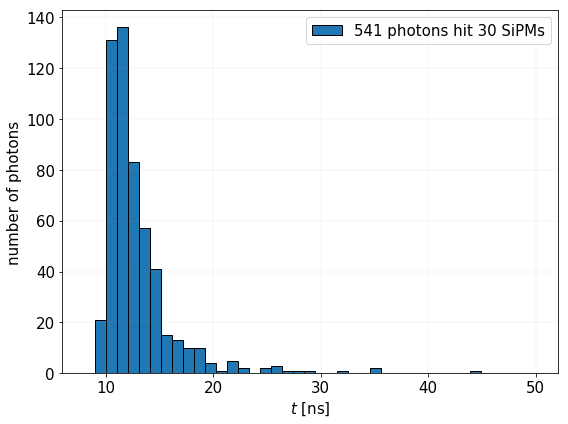

In [8]:
# time distribution of the arriving photons
time_bins=np.linspace(8,50,42)
figure,ax = plt.subplots(figsize=(8,6));
h = plt.hist( InSiPMarea.TimeFromStart*1e9 , bins=time_bins , label='%d photons hit 30 SiPMs'%len(InSiPMarea), edgecolor='black')
ax.set_xlabel('$t$ [ns]',fontsize=15);
ax.set_ylabel('number of photons',fontsize=15);
set_axes_fontsize(ax,15)
ax.grid(linewidth=0.1)
ax.legend(fontsize=15)
plt.tight_layout()

# Time resolution: 

Threshold detection of Nth = 5 photons in simulation:
- Focus on photons that hit active SiPMs within the array 
- Extract the arrival time t(n) of photon number n, accounting for SiPM fill factor and PDE. 
￼- Repeat the simulation 200 times, to form the distribution of tn. 

In [9]:
def ProtonDetectionTime( InSiPMarea, NPhotonsThreshold=5, FillFactorSiPM=0.97, PDE=0.31, fdebug=1 ):#{
    # photon detection probability = PDE * geometrical efficiency
    Pdetection = FillFactorSiPM * PDE;
    detectionTime = np.nan;

    # sort arrival times
    SortedTimes = np.sort(InSiPMarea.TimeFromStart*1e9);

    # for each photon, ask if was detected or not
    n_detected=0;
    n_photon = 0;
    while n_detected <= NPhotonsThreshold & n_photon<len(InSiPMarea): #{
        if np.random.uniform() <= Pdetection:#{
            n_detected += 1;
            detectionTime = SortedTimes[n_photon];
        #}
        n_photon += 1;
    #}

                
    if fdebug: #{        

        print "FillFactorSiPM: ", FillFactorSiPM
        print "PDE: ", PDE
        print "n_detected: ",n_detected
        print "n_photon: ",n_photon
        print "arrival time of %dth photon is %.2f ns"%(n_photon,detectionTime)
    #}    
    
    return detectionTime
#}

ProtonDetectionTime( InSiPMarea, NPhotonsThreshold=5 );

FillFactorSiPM:  0.97
PDE:  0.31
n_detected:  2
n_photon:  8
arrival time of 8th photon is 9.88 ns


In [30]:
NPhotonsThreshold=5
t_n = dict()
for l in [100,200,300]:
    t_n[l]=dict()
    NSiPMs[l]=dict();
    for NPhotonsThreshold in [5, 100]:
        t_n[l][NPhotonsThreshold]=[];
        NSiPMs[l][NPhotonsThreshold]=[];


for repIdx in np.arange(1,201,1):#{
    for l in [100,200,300]:
        for NPhotonsThreshold in [5, 100]:
            [InSiPM,PhotonsInExit] = ComputeNPhotonsArrivingAtWGmarginExit(WGname='WG_side27mm_length%d_margin3cm'%l,repIdx=repIdx);
            t_n[l][NPhotonsThreshold].append( ProtonDetectionTime(InSiPM, NPhotonsThreshold=NPhotonsThreshold, fdebug=0 ) );
            NSiPMs[l][NPhotonsThreshold].append( len(InSiPM) );
#}    

print 'done.'

done.


In [32]:
# t_n,NSiPMs = dict(),dict()
# t_n[100] = t_n_100;
# t_n[200] = t_n_200;
# t_n[300] = t_n_300;

# NSiPMs[100] = N_100;
# NSiPMs[200] = N_200;
# NSiPMs[300] = N_300;

mean_t_n,std_t_n = dict(),dict()
for l in [100,200,300]:
    mean_t_n[l] = dict()
    std_t_n[l] = dict()
    for NPhotonsThreshold in [5, 100]:
        mean_t_n[l][NPhotonsThreshold] = np.mean(t_n[l][NPhotonsThreshold])
        std_t_n[l][NPhotonsThreshold] = np.std(t_n[l][NPhotonsThreshold])

l= 100 mm mean: 9.05857485 ,std: 0.1013266184374939 ns
l= 100 mm mean: 9.07513285 ,std: 0.10148955047381723 ns
l= 200 mm mean: 9.8098074 ,std: 0.09420964689053864 ns
l= 200 mm mean: 9.8402081 ,std: 0.09671909592417607 ns
l= 300 mm mean: 10.618298 ,std: 0.09947474953977012 ns
l= 300 mm mean: 10.63473 ,std: 0.10167493053845664 ns


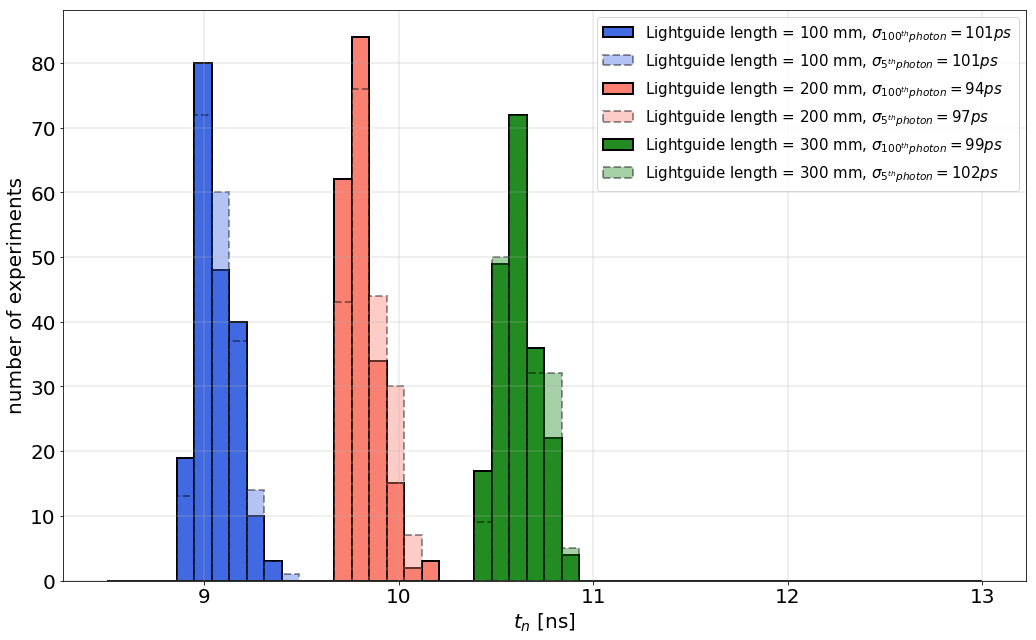

In [39]:
# distribution of the detection times
figure,ax = plt.subplots(figsize=(14.5,9));


for l,l_color in zip([100,200,300],['royalblue','salmon','forestgreen']):
    for NPhotonsThreshold,linestyle,alpha in zip([100, 5],['-','--'],[1,0.4]):
        h = plt.hist( t_n[l][NPhotonsThreshold] , 
                     bins=np.linspace(8.5,13,51), linewidth=2,
                     edgecolor='black', facecolor=l_color,linestyle=linestyle,alpha=alpha,
                     label='Lightguide length = %d mm, $\sigma_{%d^{th} photon} = %.0f ps$'%(l,NPhotonsThreshold,1000*std_t_n[l][NPhotonsThreshold])) # , facecolor='salmon'
        print 'l=',l,'mm','mean:',mean_t_n[l][NPhotonsThreshold],',std:',std_t_n[l][NPhotonsThreshold],'ns'

ax.set_xlabel('$t_{n}$ [ns]',fontsize=20);
ax.set_ylabel('number of experiments',fontsize=20);
set_axes_fontsize(ax,20)
ax.grid(linewidth=0.4)
plt.tight_layout()
plt.legend(fontsize=15)